<a href="https://colab.research.google.com/github/willy-arison/Signal-Processing/blob/main/signal_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import librosa
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import IPython.display as ipd

In [ ]:
from pathlib import Path
dir_path = '/content/drive/MyDrive/Project_3/'
audio_classes = ['Normal', 'Wheezing']

In [ ]:
audio_path= dir_path + 'Normal/BP30_N,N,P R M,18,F.wav'
audio_data, sample_rate=librosa.load(audio_path)
ipd.Audio(audio_path)

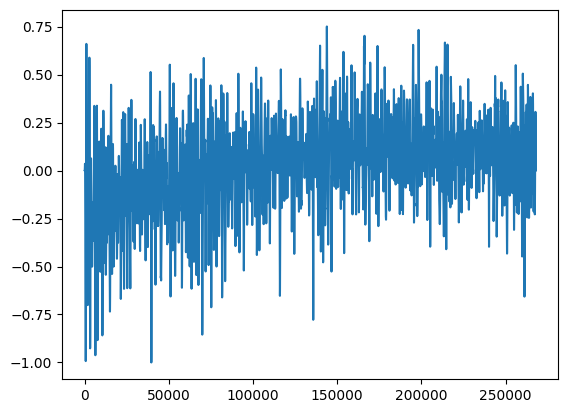

In [ ]:
plt.plot(audio_data)
plt.show()

In [ ]:
mfccs = librosa.feature.mfcc(y=audio_data, sr=sample_rate, n_mfcc=40)
mfccs.shape

(40, 524)

In [ ]:
def time_stretch_audio(audio, sr, target_length_sec):
    current_length = len(audio) / sr
    rate = current_length / target_length_sec
    stretched = librosa.effects.time_stretch(audio, rate=rate)
    return stretched

# Usage
audio, sr = librosa.load(audio_path)
audio = time_stretch_audio(audio, sr, target_length_sec=15.0)
mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40)
mfccs.shape

(40, 646)

In [ ]:
# Create features from audio waves

Normal = list(Path(dir_path+audio_classes[0]).rglob('*.wav'))
Wheezing = list(Path(dir_path+audio_classes[1]).rglob('*.wav'))
len(Normal), len(Wheezing)

x = np.zeros((105+129, 40, 646))
y = np.zeros(105+129)

for i, path in enumerate(Normal + Wheezing):
    audio, sr = librosa.load(path)
    audio = time_stretch_audio(audio, sr, target_length_sec=15.0)
    feature = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40)
    x[i] = feature
    if i < len(Normal):
        y[i] = 0
    else:
        y[i] = 1

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create dataloader
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

x_tensor, y_tensor = torch.from_numpy(x).float(), torch.from_numpy(y).long()
x_tr, x_te, y_tr, y_te = train_test_split(x_tensor, y_tensor, test_size=0.2)

train_data = TensorDataset(x_tr, y_tr)
test_data = TensorDataset(x_te, y_te)

train_loader = DataLoader(train_data, batch_size=8, shuffle=True)
test_loader = DataLoader(test_data, batch_size=8, shuffle=False)

In [ ]:
from torch.autograd import Function

class ActGHFFunction(Function):
    @staticmethod
    def forward(ctx, s, t, m1, m2):

        # Forward computation
        num = 1 + m1 * t
        den = 1 + m2 * t * torch.exp(-s/t)
        output = num / den

        # Save for backward pass
        ctx.save_for_backward(t, m1, m2, output)
        return output

    @staticmethod
    def backward(ctx, grad_output):
        t, m1, m2, output = ctx.saved_tensors

        # Compute gradient using the provided formula
        grad_s = (1/t) * output * (1 - (1/(1 + m1*t)) * output)

        # Return gradients (None for fixed params t, m1, m2)
        return grad_output * grad_s, None, None, None

class ActGHF(nn.Module):
    def __init__(self, t=0.5, m1=-1.001, m2=50):
        super(ActGHF, self).__init__()
        # Register as buffers since they're fixed parameters
        self.register_buffer('t', torch.tensor(float(t)))
        self.register_buffer('m1', torch.tensor(float(m1)))
        self.register_buffer('m2', torch.tensor(float(m2)))

    def forward(self, s):
        return ActGHFFunction.apply(s, self.t, self.m1, self.m2)

In [ ]:
import torch.nn.functional as F
import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor
from pytorch_lightning.callbacks import EarlyStopping
from torchmetrics import Accuracy

class Classifier(pl.LightningModule):
    def __init__(self, model, num_classes=10):
        super().__init__()
        self.model = model
        self.cross_entropy_loss = nn.CrossEntropyLoss()
        self.test_accuracy = Accuracy(task="multiclass", num_classes=num_classes)

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self.model(x)
        loss = self.cross_entropy_loss(logits, y)
        self.log('train_loss', loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self.model(x)
        loss = self.cross_entropy_loss(logits, y)
        acc = (logits.argmax(dim=1) == y).float().mean()
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', acc, prog_bar=True)
        return {'val_loss': loss, 'val_acc': acc}

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters())
        return optimizer


    def test_step(self, batch, batch_idx):
        x, y = batch
        preds = self(x)  # Forward pass
        self.test_accuracy(preds, y)  # Update accuracy metric
        return preds

    def on_test_epoch_end(self):
        self.log("test_acc", self.test_accuracy.compute(), prog_bar=True)


def create_trainer(model_name, max_epochs=5):
    import logging
    logging.getLogger("pytorch_lightning").setLevel(logging.WARNING)

    return pl.Trainer(
        accelerator="gpu",
        strategy="auto",
        precision="16-mixed",
        devices=-1,
        max_epochs=max_epochs,
        logger=pl.loggers.TensorBoardLogger('results/', name=model_name),
        check_val_every_n_epoch=3,
        callbacks=[
            LearningRateMonitor(),
            EarlyStopping(monitor="val_acc", mode="max", patience=4),
            # Add this callback to save the best model
            pl.callbacks.ModelCheckpoint(
                monitor="val_acc",        # Metric to monitor
                mode="max",               # Save when max accuracy
                save_top_k=1,             # Save only the best model
                filename="{epoch}-{val_acc:.4f}",  # Include accuracy in filename
                save_last=False,          # Don't save final epoch if not best
                verbose=True              # Print when new best model is saved
            )
        ],
    )



class CNN(nn.Module):
    def __init__(self, activation_fn=nn.ReLU(), in_channels=40):
        super(CNN, self).__init__()

        # Convolutional network
        self.sequential1 = nn.Sequential(
            # Convolution 1
            nn.Conv1d(in_channels=in_channels, out_channels=16, kernel_size=40),
            nn.BatchNorm1d(16),
            activation_fn,

            # Convolution 2
            nn.Conv1d(in_channels=16, out_channels=32, kernel_size=8),
            nn.BatchNorm1d(32),
            activation_fn,
            nn.MaxPool1d(kernel_size=4),
            )

        # Fully connected network
        self.sequential2 = nn.Sequential(
            nn.Linear(4800, 128),
            nn.BatchNorm1d(128),
            activation_fn,
            nn.Linear(128, 2),

        )

    def forward(self, x):
        x = self.sequential1(x)
        x = x.view(x.shape[0], -1)
        x = self.sequential2(x)
        return x

In [ ]:
activation = {
    'GHF': ActGHF(t=0.3),
    'ReLU': nn.ReLU(),
    'Mish': nn.Mish(),
    'Logistic': nn.Sigmoid(),
    'Tanh': nn.Tanh(),
    'LReLU': nn.LeakyReLU()
}
for name, act in activation.items():
    model = CNN(activation_fn=act)
    print('Train with: ', name)
    trainer = create_trainer(name, max_epochs=50)
    classifier = Classifier(model, num_classes=2)
    trainer.fit(classifier, train_loader,test_loader)
    trainer.test(classifier, dataloaders=test_loader)

Train with:  GHF


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (24) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │     0.936170220375061     │
└───────────────────────────┴───────────────────────────┘

Train with:  ReLU


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │     0.936170220375061     │
└───────────────────────────┴───────────────────────────┘

Train with:  Mish


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8723404407501221     │
└───────────────────────────┴───────────────────────────┘

Train with:  Logistic


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │     0.914893627166748     │
└───────────────────────────┴───────────────────────────┘

Train with:  Tanh


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │     0.914893627166748     │
└───────────────────────────┴───────────────────────────┘

Train with:  LReLU


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8936170339584351     │
└───────────────────────────┴───────────────────────────┘

In [ ]:
# Path to the checkpoint file
import glob
version = 0
activation = {
    'GHF': ActGHF(),
    'ReLU': nn.ReLU(),
    'Mish': nn.Mish(),
    'Logistic': nn.Sigmoid(),
    'Tanh': nn.Tanh(),
    'LReLU': nn.LeakyReLU()
}
num_classes = 2
for name, act in activation.items():
    checkpoint_path = f"results/{name}/version_{version}/checkpoints"
    ckp_file = glob.glob(f'{checkpoint_path}/*.ckpt')

    # cnn_model = CNN(activation_fn=act)
    model = CNN(activation_fn=act)
    print('Accuracy for: ', name)
    model = Classifier.load_from_checkpoint(ckp_file[0], model=model, num_classes=2)
    results = trainer.test(model, dataloaders=test_loader)

Accuracy for:  GHF


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │     0.957446813583374     │
└───────────────────────────┴───────────────────────────┘

Accuracy for:  ReLU


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │     0.957446813583374     │
└───────────────────────────┴───────────────────────────┘

Accuracy for:  Mish


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │     0.914893627166748     │
└───────────────────────────┴───────────────────────────┘

Accuracy for:  Logistic


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │     0.936170220375061     │
└───────────────────────────┴───────────────────────────┘

Accuracy for:  Tanh


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │     0.936170220375061     │
└───────────────────────────┴───────────────────────────┘

Accuracy for:  LReLU


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │     0.957446813583374     │
└───────────────────────────┴───────────────────────────┘